Dinar Sharafutdinov, PS2

In [104]:
import numpy as np
from matplotlib import pyplot as plt
from field_map import FieldMap
from tools.data import load_data
from tools.objects import Gaussian
from skimage import io
plt.xkcd()

c:\users\dinar\yandex~1\1_4c17~1\2_f424~1\b1d8~1\percep~1\ps\2\ps2_code\venv\lib\site-packages\skimage\external\tifffile\tifffile.py:305: UserWarning: ImportError: No module named '_tifffile'. Loading of some compressed images will be very slow. Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "ImportError: No module named '_tifffile'. "


<matplotlib.pyplot.xkcd.<locals>.dummy_ctx at 0x29dac255198>

### A

'Diagonal of Standard deviations of the Observation noise Q. (format: deg).',
                        default=20)

help='Squared root of alphas, used for transition noise in action space (M_t). (format: a1 a2 a3 a4).',
                        default=(0.05, 0.001, 0.05, 0.01)

In [3]:
fm = FieldMap()
fm.landmarks_poses_x, fm.landmarks_poses_y

(array([ 21., 242., 463., 463., 242.,  21.]),
 array([  0,   0,   0, 292, 292, 292]))

It's clear from the code that betta = 20, alphas = 0.05, 0.001, 0.05, 0.01. Let's find Q, R, G, V, H

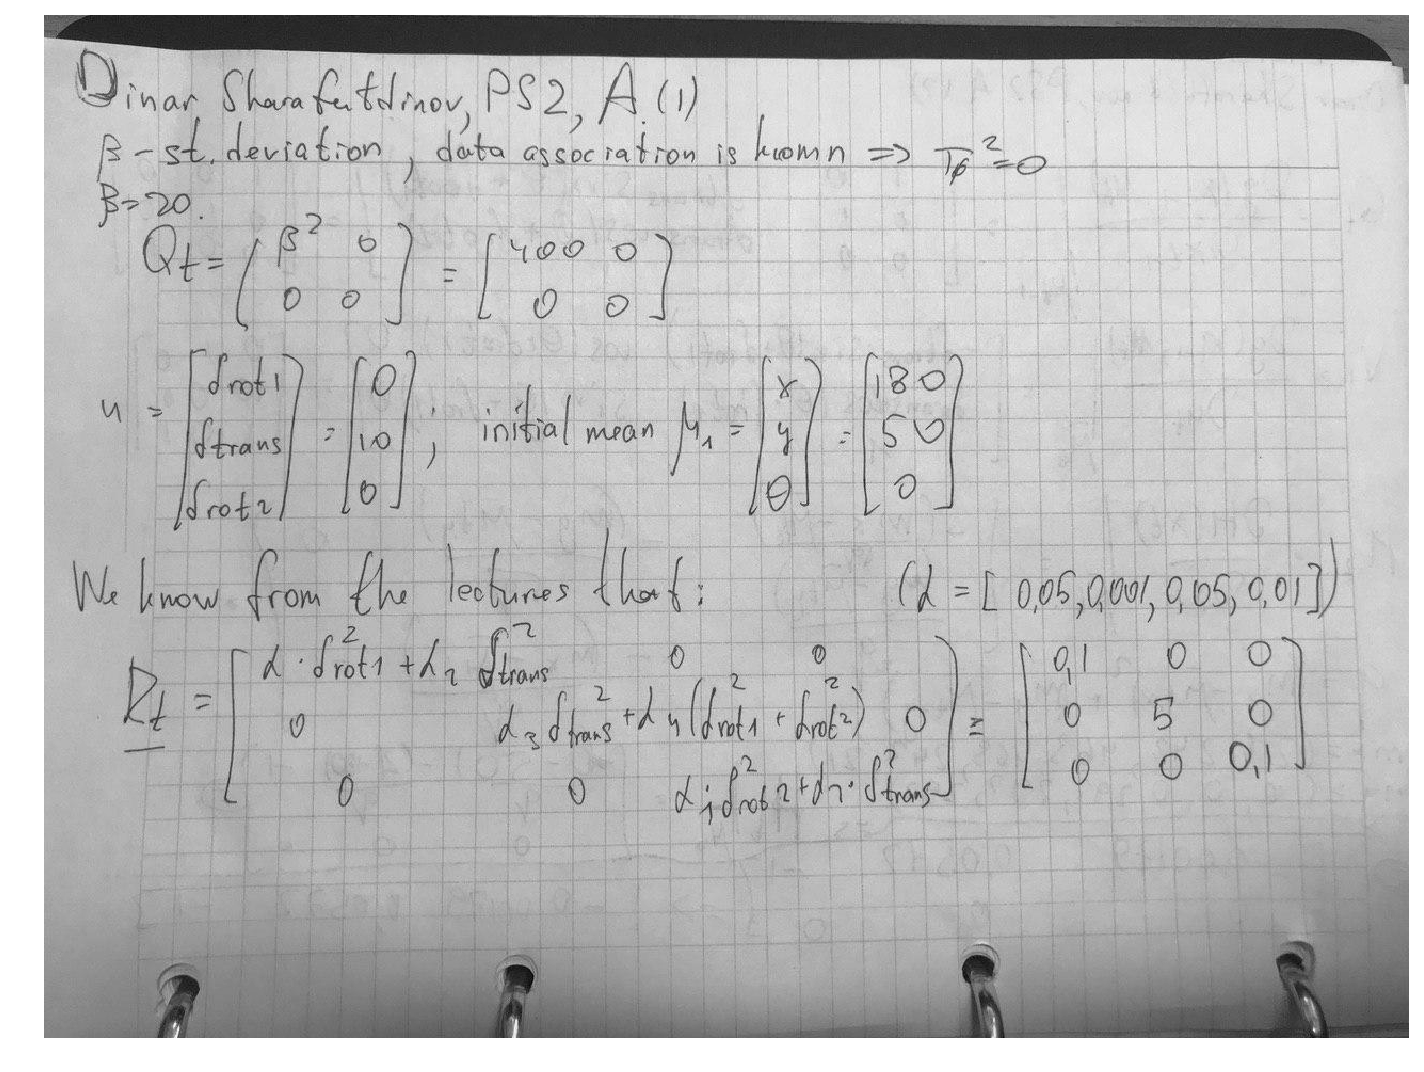

In [257]:
A_1 = io.imread('photos/A_1.jpg', as_gray=True, plugin='matplotlib')
plt.figure(figsize=[20, 20])
plt.axis('off')
io.imshow(A_1)

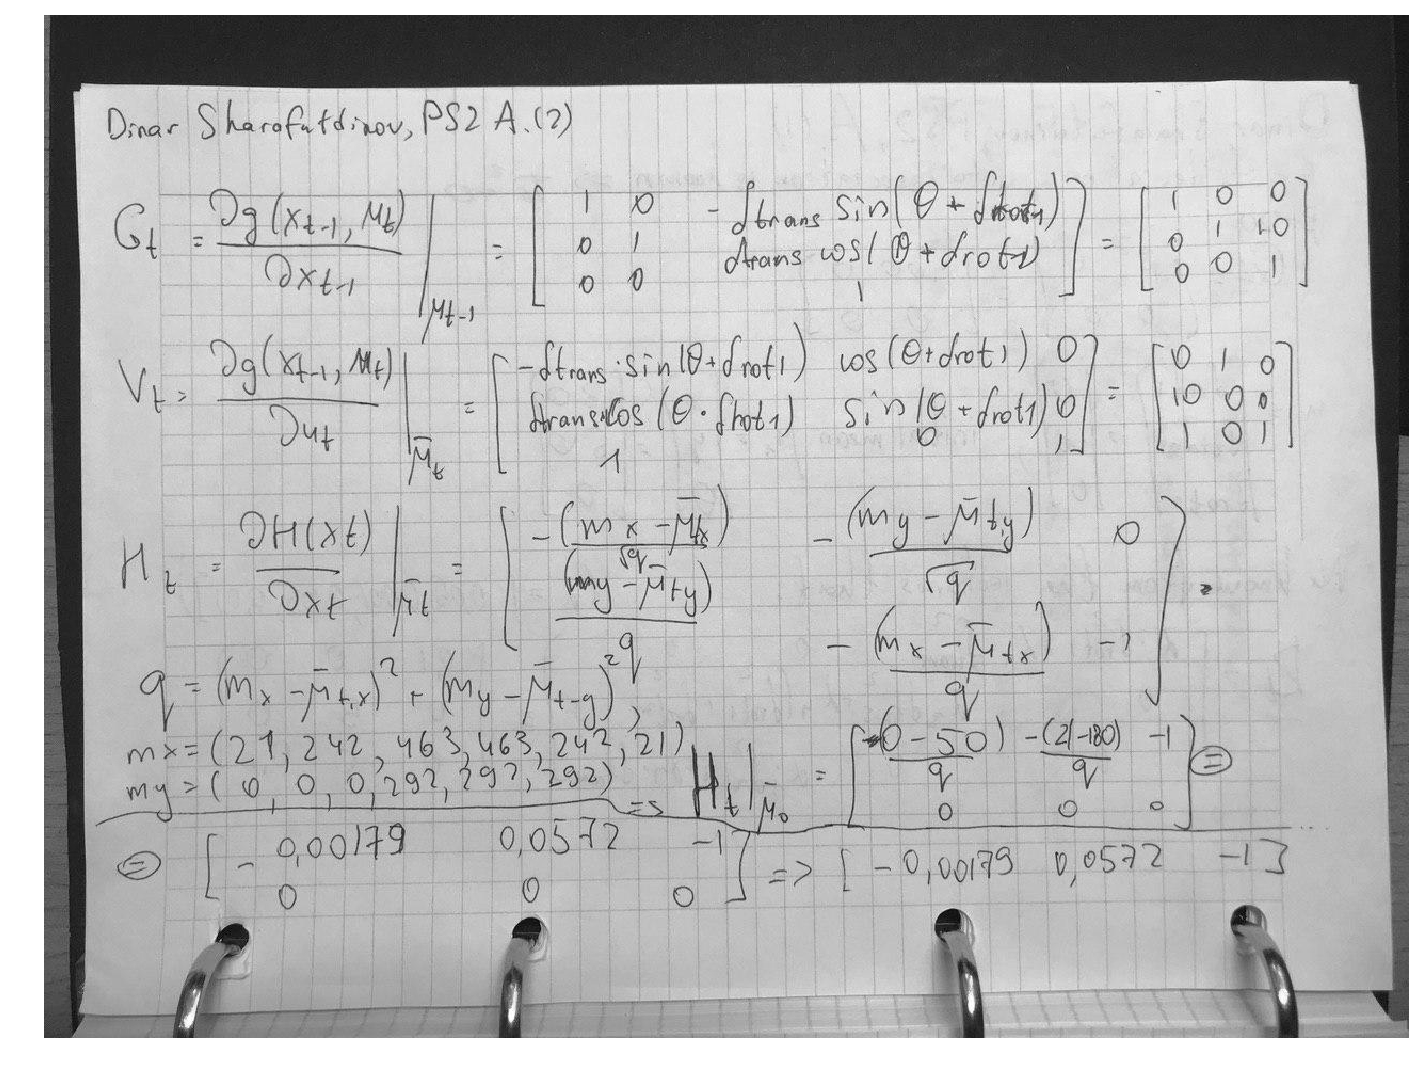

In [258]:
A_2 = io.imread('photos/A_2.jpg', as_gray=True, plugin='matplotlib')
plt.figure(figsize=[20, 20])
plt.axis('off')
io.imshow(A_2)

In [259]:
mean_prior = np.array([180., 50., 0.])

In [261]:
data_ = load_data("evaluation-input.npy")

In [262]:
data_

Real path of the robot

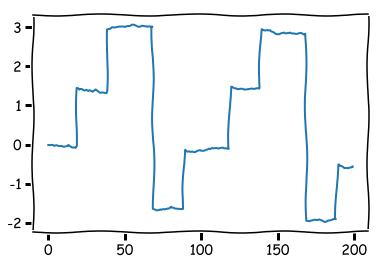

In [263]:
fig = plt.figure()
plt.plot(data_.debug.real_robot_path[:, 2])
plt.show()

For me, that was quite difficult to understand all the dependencies between .py files, so I decided to draw a scheme

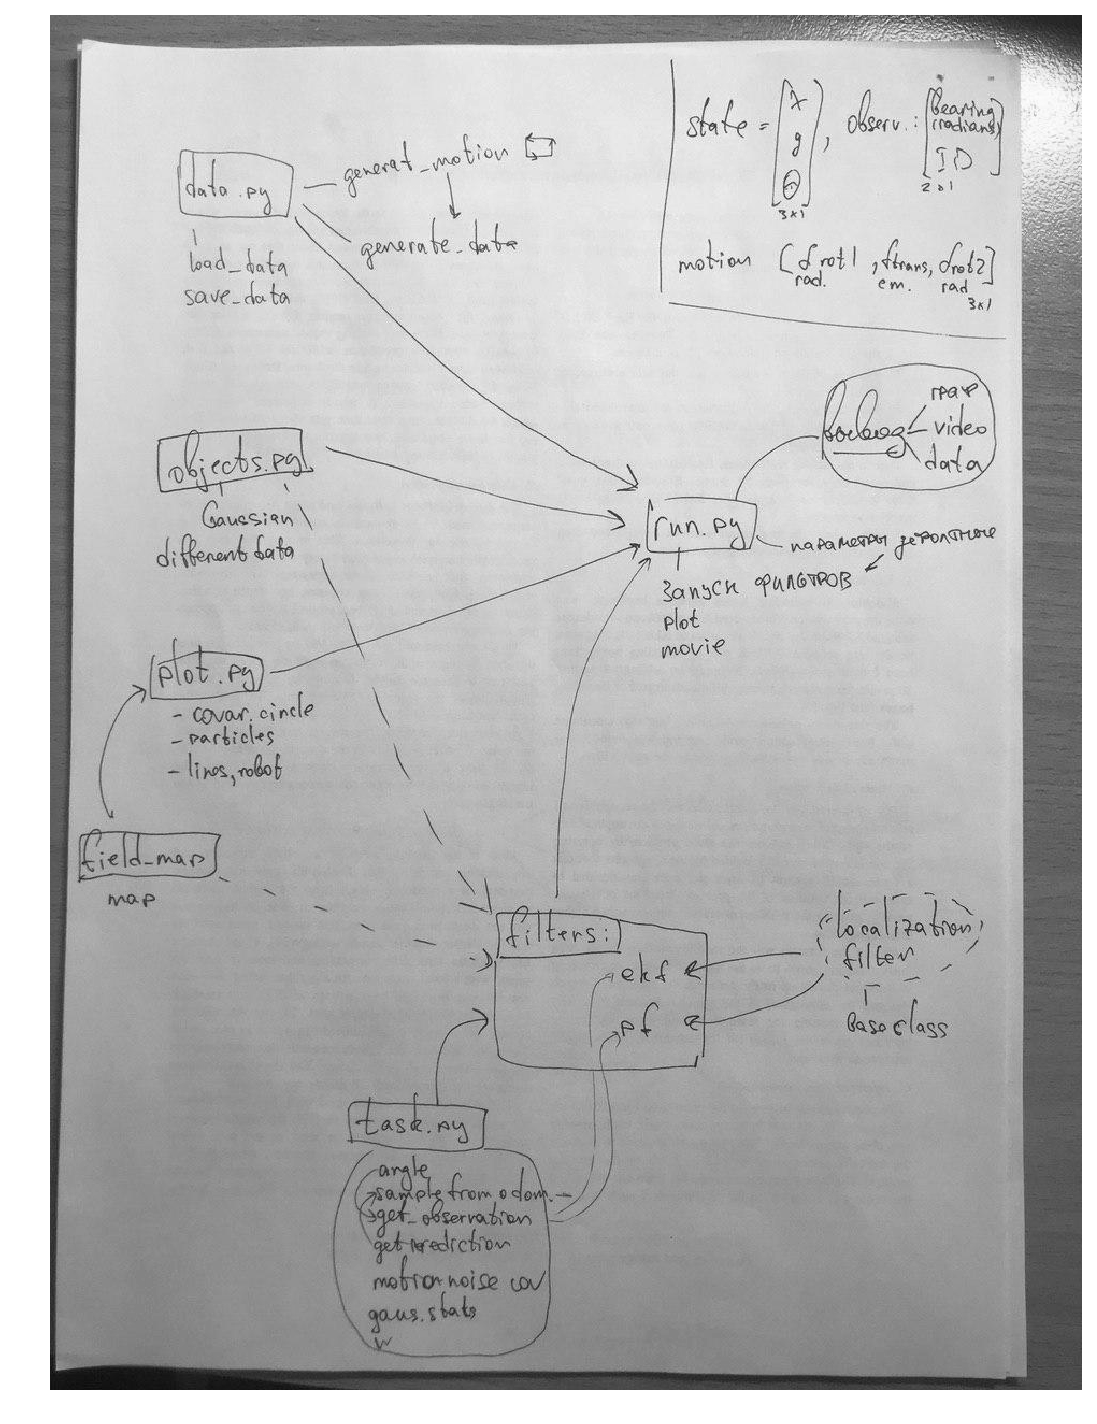

In [264]:
scheme = io.imread('photos/scheme.jpg', as_gray=True, plugin='matplotlib')
plt.figure(figsize=[20, 20])
plt.axis('off')
io.imshow(scheme)

### B

In [245]:
mean_prior = np.array([180., 50., 0.])
Sigma_prior = 1e-12 * np.eye(3, 3)
initial_state = Gaussian(mean_prior, Sigma_prior)

In [246]:
initial_state.mu.reshape(1, -1).ravel()

array([180.,  50.,   0.])

In [248]:
alphas = np.array([0.05, 0.001, 0.05, 0.01])
motion = np.array([0, 10, 0])

In [249]:
x, y, theta = mean_prior
drot1, dtrans, drot2 = motion

In [250]:
def G_jacob(state, motion):
    x, y, theta = state
    drot1, dtrans, drot2 = motion
    G = np.array([[1, 0, -dtrans * np.sin(theta + drot1)], 
                  [0, 1, dtrans * np.cos(theta + drot1)], 
                  [0, 0, 1]])
    return(G)

In [251]:
G_jacob(mean_prior, motion)

array([[ 1.,  0., -0.],
       [ 0.,  1., 10.],
       [ 0.,  0.,  1.]])

In [49]:
def V_jacob(state, motion):
    x, y, theta = state
    drot1, dtrans, drot2 = motion
    V = np.array([[-dtrans * np.sin(theta + drot1), np.cos(theta + drot1), 0],
                  [dtrans * np.cos(theta + drot1),  np.sin(theta + drot1), 0], 
                  [1, 0, 1]])
    return(V)

In [50]:
V_jacob(mean_prior, motion)

array([[-0.,  1.,  0.],
       [10.,  0.,  0.],
       [ 1.,  0.,  1.]])

In [54]:
def H_jacob(state, lm_id):
    
    lm_id = int(lm_id)
    fm = FieldMap()
    x, y, theta = state
    mx, my = fm.landmarks_poses_x[lm_id], fm.landmarks_poses_y[lm_id]
    
    q = (mx - x)**2 + (my - y)**2
    H = np.array([(my - y) / q, -(mx - x) / q, -1])
    return H

In [55]:
H_jacob(mean_prior, 0)

array([-0.00179979,  0.00572334, -1.        ])

Here we got the same results of G, V and H, as on the photo by hands

Realization of Extended Kalman Filter in ekf.py

In [ ]:
#python run.py --animate -s -f pf -n 100
#python run.py --animate -s -f ekf -i evaluation-input.npy -o out_ekf
#python run.py --animate -s -f ekf -i evaluation-input.npy -m video_ekf.mp4

Realization of Extended Kalman Filter in pf.py

In [ ]:
#python run.py --animate -f pf -n 100 --show-particles
#python run.py --animate -f pf --show-particles -i evaluation-input.npy -o out_pf
#python run.py --animate -f pf --show-particles -i evaluation-input.npy -m video_pf.mp4

### C

In [265]:
data = np.load('out_ekf/input_data.npy')
data_ekf = np.load('out_ekf/output_data.npy')
data_pf = np.load('out_pf/output_data.npy')

In [266]:
data

In [267]:
errors_ekf = data["real_robot_path"] - data_ekf['mean_trajectory']
errors_pf = data["real_robot_path"] - data_pf['mean_trajectory']

In [268]:
axis_x = np.arange(data['num_steps'])

In [269]:
sigma_x_ekf = 3 * np.sqrt(data_ekf['covariance_trajectory'][0][0])
sigma_y_ekf = 3 * np.sqrt(data_ekf['covariance_trajectory'][1][1])
sigma_th_ekf = 3 * np.sqrt(data_ekf['covariance_trajectory'][2][2])
sigma_x_pf = 3 * np.sqrt(data_pf['covariance_trajectory'][0][0])
sigma_y_pf = 3 * np.sqrt(data_pf['covariance_trajectory'][1][1])
sigma_th_pf = 3 * np.sqrt(data_pf['covariance_trajectory'][2][2])

In [270]:
def plot_err(err, sigma, title):
    fig = plt.figure(figsize=(12, 4))
    plt.plot(err, color = 'blue')
    plt.fill_between(axis_x, 0 + sigma, 0 - sigma, color = 'red')
    plt.title(title)
    plt.show()

#### EKF (plots of error vs. time with 3 sigma uncertainty bounds)

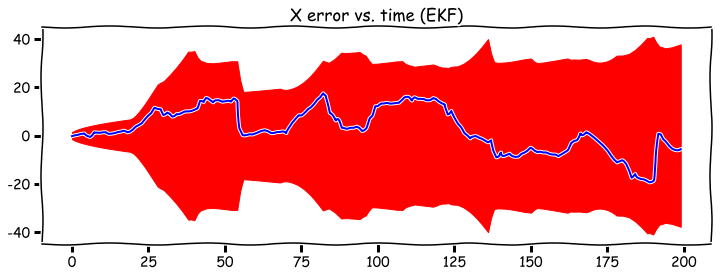

In [271]:
plot_err(errors_ekf[:, 0], sigma_x_ekf, 'X error vs. time (EKF)')

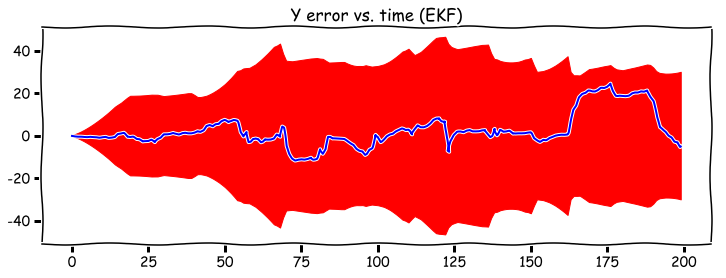

In [164]:
plot_err(errors_ekf[:, 1], sigma_y_ekf, 'Y error vs. time (EKF)')

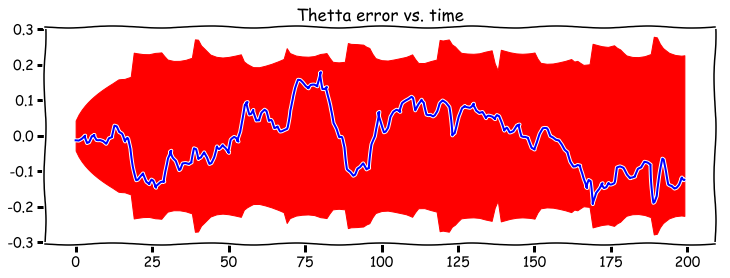

In [165]:
plot_err(errors_ekf[:, 2], sigma_th_ekf, 'Thetta error vs. time')

As we can see the majority of the time the error lies between the interval of 3 sigma

#### PF (plots of error vs. time with 3 sigma uncertainty bounds)

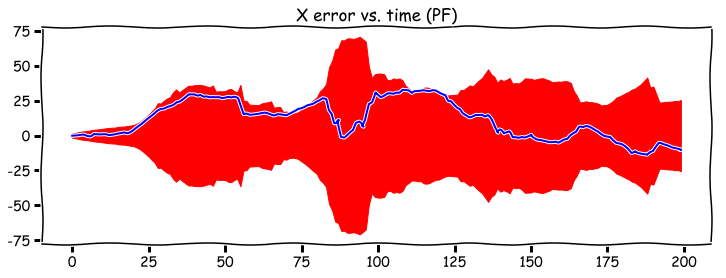

In [166]:
plot_err(errors_pf[:, 0], sigma_x_pf, 'X error vs. time (PF)')

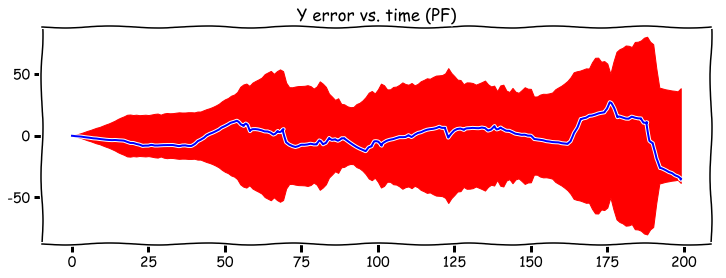

In [167]:
plot_err(errors_pf[:, 1], sigma_y_pf, 'Y error vs. time (PF)')

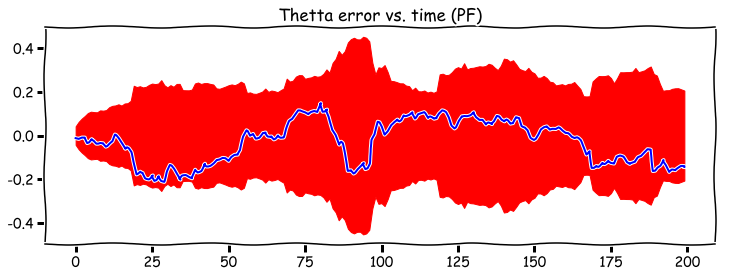

In [168]:
plot_err(errors_pf[:, 2], sigma_th_pf, 'Thetta error vs. time (PF)')

The same here. Also, we can notice that for the X error in PF case is very close to the boundary, but anyway it's inside the interval

### D

#### sensor noise go toward zero

In [ ]:
# param beta: A scalar value of the measurement noise parameter, default=20

Here we will set beta to 1, which is almost 20 times smaller and close to 0

In [280]:
data_41 = np.load('out_ekf_sens_zero0/input_data.npy')
data_ekf_41 = np.load('out_ekf_sens_zero0/output_data.npy')
errors_ekf_41 = data_41["real_robot_path"] - data_ekf_41['mean_trajectory']
axis_x_41 = np.arange(data_41['num_steps'])
sigma_x_ekf_41 = 3 * np.sqrt(data_ekf_41['covariance_trajectory'][0][0])
sigma_y_ekf_41 = 3 * np.sqrt(data_ekf_41['covariance_trajectory'][1][1])
sigma_th_ekf_41 = 3 * np.sqrt(data_ekf_41['covariance_trajectory'][2][2])

Here we can see that now since the sensor noise is small, our prediction is very close to the real path. But the error several times smaller than before (5 - max compared to 20 max before)

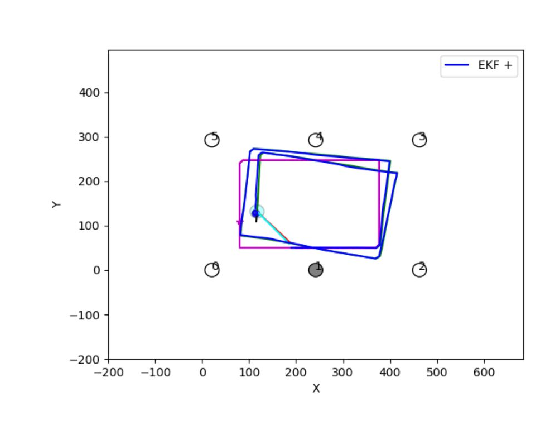

In [282]:
image_full = io.imread('out_ekf_sens_zero0/pic.jpg', plugin='matplotlib')
plt.figure(figsize=[8,8])
plt.axis('off')
io.imshow(image_full)

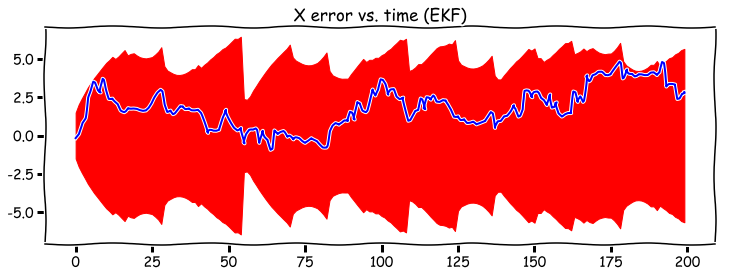

In [283]:
plot_err(errors_ekf_41[:, 0], sigma_x_ekf_41, 'X error vs. time (EKF)')

In [284]:
def plot_err2(err, sigma, title):
    fig = plt.figure(figsize=(12, 4))
    plt.plot(err, color = 'blue')
    plt.fill_between(axis_x, 0 + sigma, 0 - sigma, color = 'red')
    plt.title(title)
    plt.axis([-5, 205, -45, 45])
    plt.show()

If we will use the same limits on plot as before

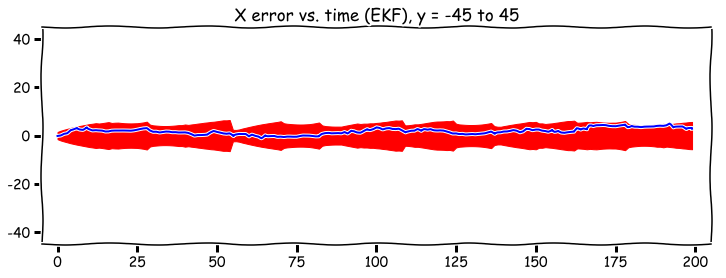

In [285]:
plot_err2(errors_ekf_41[:, 0], sigma_x_ekf_41, 'X error vs. time (EKF), y = -45 to 45')

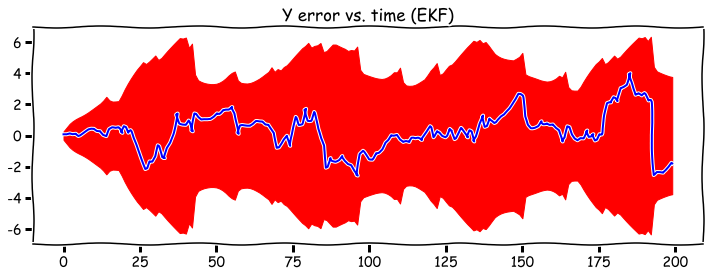

In [286]:
plot_err(errors_ekf_41[:, 1], sigma_y_ekf_41, 'Y error vs. time (EKF)')

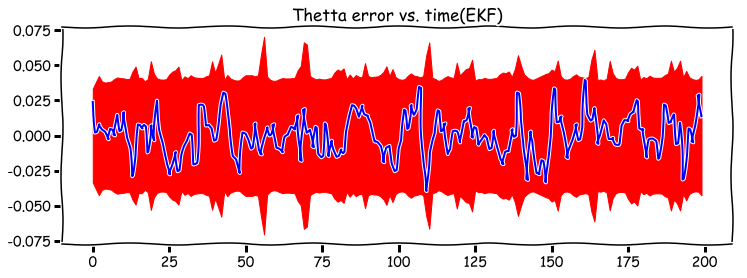

In [287]:
plot_err(errors_ekf_41[:, 2], sigma_th_ekf_41, 'Thetta error vs. time(EKF)')

#### motion noise go toward zero

In [188]:
#param alphas: A 1-d np-array of motion noise parameters, default=(0.05, 0.001, 0.05, 0.01)

Here we will set alphas much closer to zero and 10 times smaller than before (0.005, 0.0001, 0.005, 0.001))

In [296]:
data_42 = np.load('out_ekf_motion_zero10/input_data.npy')
data_ekf_42 = np.load('out_ekf_motion_zero10/output_data.npy')
errors_ekf_42 = data_42["real_robot_path"] - data_ekf_42['mean_trajectory']
axis_x_42 = np.arange(data_42['num_steps'])
sigma_x_ekf_42 = 3 * np.sqrt(data_ekf_42['covariance_trajectory'][0][0])
sigma_y_ekf_42 = 3 * np.sqrt(data_ekf_42['covariance_trajectory'][1][1])
sigma_th_ekf_42 = 3 * np.sqrt(data_ekf_42['covariance_trajectory'][2][2])

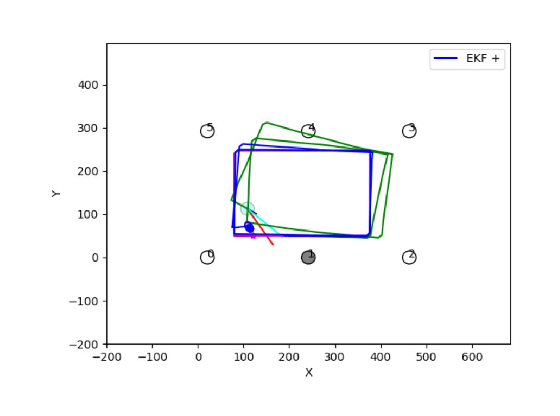

In [303]:
image_full = io.imread('out_ekf_motion_zero10/pic.jpg', plugin='matplotlib')
plt.figure(figsize=[8, 8])
plt.axis('off')
io.imshow(image_full)

We see that now since the motion noise is very small our prediction is very close to the ideal path but totally not to the real one. That's why the error is quite high and out of boundaries. Also, the variance is very small because of little noise in the motion

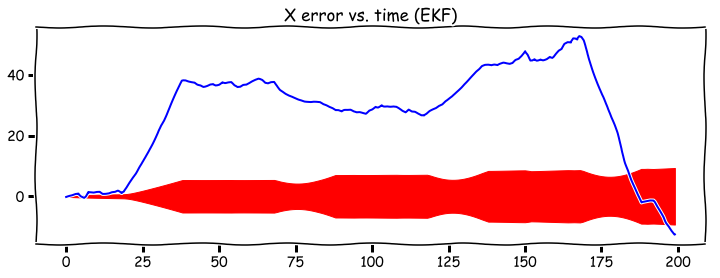

In [304]:
plot_err(errors_ekf_42[:, 0], sigma_x_ekf_42, 'X error vs. time (EKF)')

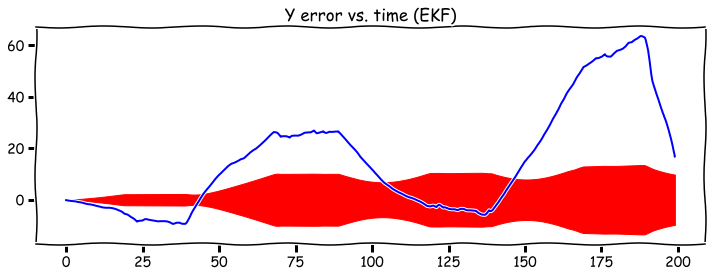

In [305]:
plot_err(errors_ekf_42[:, 1], sigma_y_ekf_42, 'Y error vs. time (EKF)')

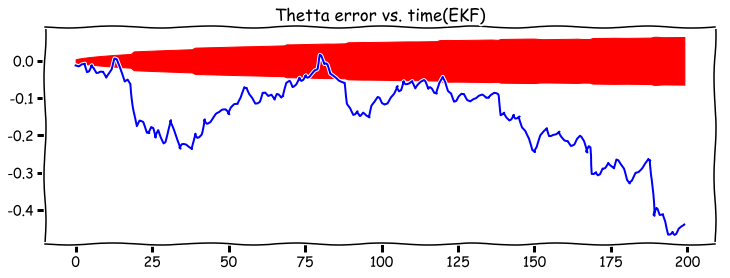

In [306]:
plot_err(errors_ekf_42[:, 2], sigma_th_ekf_42, 'Thetta error vs. time(EKF)')

#### the number of particles decrease

Let's look at the particles filter. First, for the case of 50 particles which is twice smaller than before. Then let's look at 10 particles, which is 10 times smaller than in the initial experiment

##### 50

In [235]:
data_43 = np.load('out_pf_num_p_50/input_data.npy')
data_pf_43 = np.load('out_pf_num_p_50/output_data.npy')
errors_pf_43 = data_43["real_robot_path"] - data_pf_43['mean_trajectory']
axis_x_43 = np.arange(data_43['num_steps'])
sigma_x_pf_43 = 3 * np.sqrt(data_pf_43['covariance_trajectory'][0][0])
sigma_y_pf_43 = 3 * np.sqrt(data_pf_43['covariance_trajectory'][1][1])
sigma_th_pf_43 = 3 * np.sqrt(data_pf_43['covariance_trajectory'][2][2])

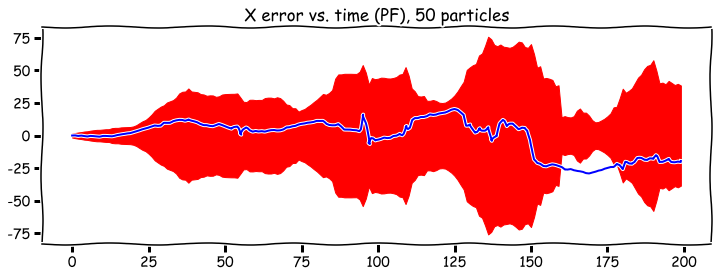

In [236]:
plot_err(errors_pf_43[:, 0], sigma_x_pf_43, 'X error vs. time (PF), 50 particles')

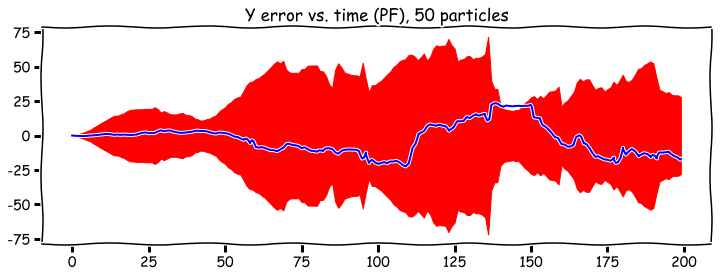

In [237]:
plot_err(errors_pf_43[:, 1], sigma_y_pf_43, 'Y error vs. time (PF), 50 particles')

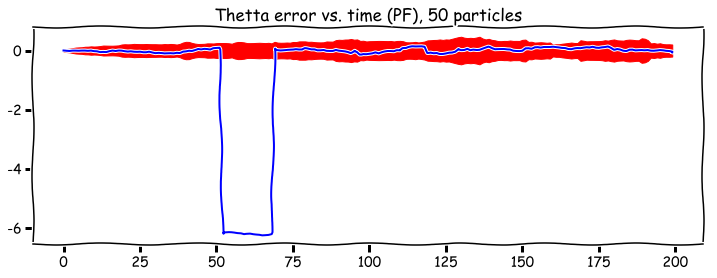

In [238]:
plot_err(errors_pf_43[:, 2], sigma_th_pf_43, 'Thetta error vs. time (PF), 50 particles')

We see that besides several bad cases in general error inside the bounds of 3 sigma

##### 10

In [240]:
data_43 = np.load('out_pf_num_p_10/input_data.npy')
data_pf_43 = np.load('out_pf_num_p_10/output_data.npy')
errors_pf_43 = data_43["real_robot_path"] - data_pf_43['mean_trajectory']
axis_x_43 = np.arange(data_43['num_steps'])
sigma_x_pf_43 = 3 * np.sqrt(data_pf_43['covariance_trajectory'][0][0])
sigma_y_pf_43 = 3 * np.sqrt(data_pf_43['covariance_trajectory'][1][1])
sigma_th_pf_43 = 3 * np.sqrt(data_pf_43['covariance_trajectory'][2][2])

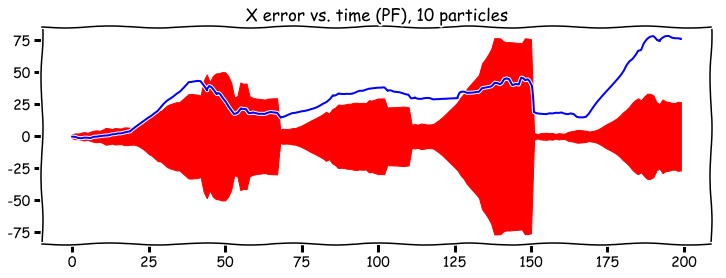

In [241]:
plot_err(errors_pf_43[:, 0], sigma_x_pf_43, 'X error vs. time (PF), 10 particles')

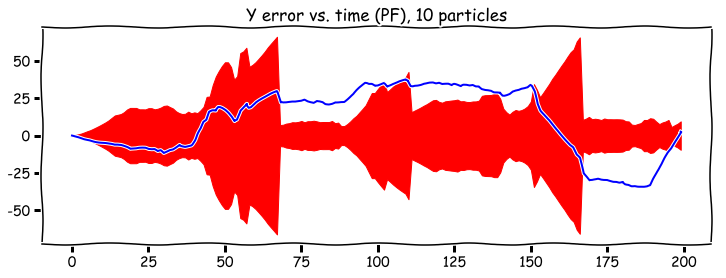

In [242]:
plot_err(errors_pf_43[:, 1], sigma_y_pf_43, 'Y error vs. time (PF), 10 particles')

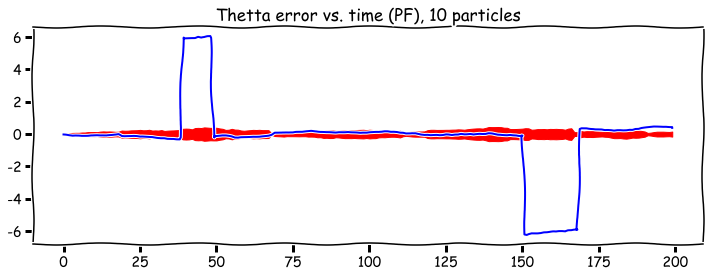

In [243]:
plot_err(errors_pf_43[:, 2], sigma_th_pf_43, 'Thetta error vs. time (PF), 10 particles')

Here results are different. We see that error often out of the bounds which means that smaller the amount of particles we use in PF worse our results 

So, these experiments show us that it is important to properly estimate noise. Because, if we have wrong estimation of both sensor or motion noise we will get not accurate results in terms of quality of predicton of the real path